явная    неявная      аналитическое
0.0 0.0 0.0 0.0
0.0 3.4849979890534947e-09 6.956118044948732e-45 4.030058591699709e-11
0.0 1.9292414359320437e-08 1.3404299000715686e-23 4.563068588256847e-10
0.0 6.759197505508713e-08 1.4642551942775935e-16 2.935652596065509e-09
0.0 1.823715164608274e-07 4.482430407778621e-13 1.3228527499938372e-08
0.0 4.1268517854744624e-07 5.2754483403376534e-11 4.6034812293299804e-08
0.0 8.213711792729677e-07 1.2264882367543856e-09 1.312613155180413e-07
0.0 1.4816855264783154e-06 1.1337397432732574e-08 3.1941493476914507e-07
0.0 2.4725644044254095e-06 5.905382554594784e-08 6.836055979869704e-07
0.0 3.873343032688133e-06 2.102505488263888e-07 1.316819705092254e-06
6.736143618764052e-08 5.758674585160339e-06 5.743030698244559e-07 2.3249269976483092e-06
3.5325277176315997e-07 8.194198595262847e-06 1.2950188306235077e-06 3.817207918734788e-06
1.0607774662447708e-06 1.1233281851363069e-05 2.530943549883603e-06 5.896562676476006e-06
2.4002311800525177e-06 1.49149483265

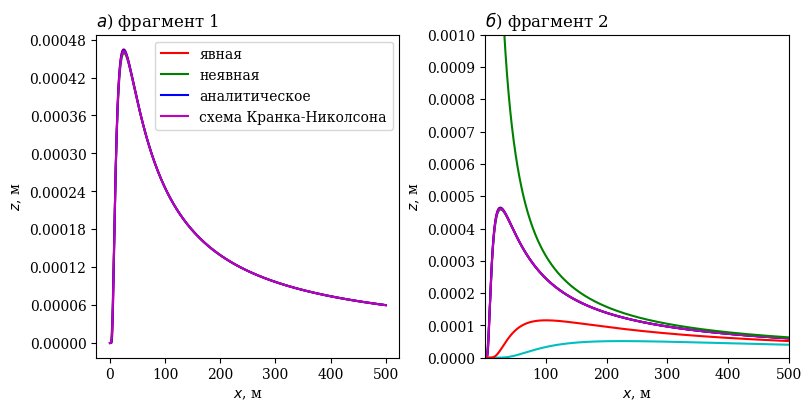

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D


rc('font', **{'family': 'serif'})
# источник мощностью M на высоте H
M = 1.4
H = 100.0

# рассматриваем задачу с постоянными коэффициентами
kz = 5.0
k0 = 0.5
u = 5.0
uH = u
ky = k0 * u
y = 0.

# определяем границы расчетной области, шаг и сетку
zmax = 300.
xmax = 500. + 0.001
#dx = 0.1
dx = 0.25
dz = 1

x = np.arange(0.001, xmax+dx, dx)
z = np.arange(0, zmax+dz, dz)

n = z.size - 1
m = x.size - 1
# в общем случае скорость ветра и к-т турбулентности - функции от z
uf = np.ones(n+1)
kf = np.ones(n+1)
# но сейчас задаем их константами
uf = uf * u
kf = kf * kz

# массив c - решение задачи для линейного источника в явной задаче
# массив cpoint - решение задачи для точечного источника при y=0
c = np.zeros((n+1, m+1))
cpoint = np.zeros((n+1, m+1))
# массив cn - решение задачи для линейного источника в неявной задаче
cn = np.zeros((n+1, m+1))
# массив ck - решение задачи для линейного источника по схеме Кранка-Николсона
ck = np.zeros((n+1, m+1))
# массив c1 - аналитическое решение при y = 0
c1 = np.zeros((n+1, m+1))

# определяем номер узла, соответствующго источнику
iH, = np.where(z == 100)
# и задаем начальное условие в этом узле
c[iH, 0] = M/(uH * dz)
cn[iH, 0] = M/(uH * dz)
ck[iH, 0] = M/(uH * dz)


def progon(A, C, B, F, Y):

    alfa = np.zeros(n + 1)
    beta = np.zeros(n + 1)

    # прямой ход метода прогонки
    # вычисление коэффициентов прогонки
    alfa[0] = B[0] / C[0]
    beta[0] = F[0] / C[0]
    for i in range(1, n + 1):
        alfa[i] = B[i] / (C[i] - alfa[i - 1] * A[i])
        beta[i] = (A[i] * beta[i - 1] + F[i]) / (C[i] - alfa[i - 1] * A[i])

    # обратный ход метода прогонки
    Y[i] = beta[n]
    for i in range(n - 1, -1, -1):
        Y[i] = alfa[i] * Y[i+1] + beta[i]


# вычисление по явной схеме
for j in range(m):
    for i in range(1, n-1):
        sigma = dx / (uf[i] * dz ** 2)
        k_minus = 0.5 * (kf[i] + kf[i-1])
        k_plus = 0.5 * (kf[i] + kf[i+1])
        #c[i, j+1] = (sigma * k_plus * c[i+1, j] + (1- sigma * (k_minus + k_plus)) * c[i, j]
         #           + sigma * k_minus * c[i-1, j])
        c[i, j + 1] = (sigma * (k_plus * c[i + 1, j] + k_minus * c[i - 1, j]) +
                       (1 - sigma * (k_minus + k_plus)) * c[i, j])

    c[0, j+1] = c[1, j+1]
    c[n, j] = 0

for j in range(1, m):
    for i in range(n):
        cpoint[i,j] = c[i,j] / (2 * math.sqrt(math.pi * k0 * x[j]))
# вычисление по явной схеме выполнено

# определение массивов для коэффициентов системы для метода прогонки
# в чисто неявной схеме и схеме Кранка-Николсона
A = np.zeros(n+1)
C = np.zeros(n+1)
B = np.zeros(n+1)
F = np.zeros(n+1)

# вычисление по чисто неявной схеме
for j in range(1, m+1):
    # вычисление коэффциентов системы уравнений
    C[0] = 1.; B[0] = 1.; F[0] = 0.
    C[n] = 1.; A[n] = 0.; F[n] = 0.
    for i in range(1,n):
        sigma = uf[i] * dz ** 2 / dx
        k_minus = 0.5 * (kf[i] + kf[i - 1])
        k_plus = 0.5 * (kf[i] + kf[i + 1])
        A[i] = k_minus
        C[i] = k_plus + k_minus + sigma
        B[i] = k_plus
        F[i] = sigma * cn[i, j-1] #*0.983
    progon(A, C, B, F, cn[:, j])
# вычисление по неявной схеме выполнено

# вычисление по схеме Кранка-Николсона
for j in range(1, m+1):
    # вычисление коэффциентов системы уравнений
    C[0] = 1.; B[0] = 1.; F[0] = 0.
    C[n] = 1.; A[n] = 0.; F[n] = 0.
    for i in range(1,n):
        sigma = uf[i] * dz ** 2 / dx
        k_minus = 0.5 * (kf[i] + kf[i - 1])
        k_plus = 0.5 * (kf[i] + kf[i + 1])
        A[i] = k_minus
        C[i] = k_plus + k_minus + 2 * sigma
        B[i] = k_plus
        F[i] = (2 * sigma * ck[i,j-1] + k_plus * (ck[i+1,j-1] - ck[i,j-1])
        - k_minus * (ck[i,j-1] - ck[i-1,j-1]))


    progon(A, C, B, F, ck[:, j])

# вычисление по схеме Кранка-Николсона выполнено
# аналитическое решение при y = 0
# расчет для y = 0; вертикальная плоскость

#y = 0.
#c1 = (M/(4 * math.pi * x * math.sqrt(ky * kz))
#    * np.exp(-u * y ** 2 / (4 * ky * x))
#    * (np.exp(-u * (z + H) ** 2/(4 * kz * x))+np.exp(-u * (z - H) ** 2/(4 * kz * x)))
#)

xgrid, zgrid = np.meshgrid(x, z)

# определение линий уровня и цветов
lev = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.016, 0.020, 0.030, 0.040, 0.300]
clr = ['cyan', 'turquoise', 'teal', 'steelblue', 'cornflowerblue', 'mediumslateblue',
       'indigo', 'darkmagenta', 'orchid', 'lightpink', 'hotpink']

# выводим два графика рядом
# решение задачи для линейного источника по явной и неявной схеме
fg = plt.figure(figsize=(8, 4), constrained_layout=True)
widths = [1, 1]

gs = fg.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax1 = fg.add_subplot(gs[0, 0])
#ax1.contourf(xgrid, zgrid, c, levels=lev, colors=clr )
temp = np.zeros(m+1)
temp1 = np.zeros(m+1)
temp2 = np.zeros(m+1)
temp3 = np.zeros(m+1)
temp4 = np.zeros(m+1)
temp5 = np.zeros(m+1)
temp6 = np.zeros(m+1)
iH, = np.where(z == 90)

temp[:]  = c[iH, :] / (2 * np.sqrt(math.pi * k0 * x[:])) * np.exp(-y ** 2/(4 * k0 * x[:]))
temp1[:] = cn[iH, :] / (2 * np.sqrt(math.pi * k0 * x[:])) * np.exp(-y ** 2 / (4 * k0 * x[:]))
temp2[:] = (M / (4 * math.pi * x[:] * math.sqrt(ky * kz))
            * np.exp(-u * y ** 2 / (4 * ky * x[:]))
            * (np.exp(-u * (z[iH] + H) ** 2 / (4 * kz * x[:])) + np.exp(-u * (z[iH] - H) ** 2 / (4 * kz * x[:])))
            )
temp3[:] = ck[iH, :] / (2 * np.sqrt(math.pi * k0 * x[:])) * np.exp(-y ** 2 / (4 * k0 * x[:]))

iH, = np.where(z == 70)
temp4[:] = ck[iH, :] / (2 * np.sqrt(math.pi * k0 * x[:])) * np.exp(-y ** 2 / (4 * k0 * x[:]))
iH, = np.where(z == 80)
temp5[:] = ck[iH, :] / (2 * np.sqrt(math.pi * k0 * x[:])) * np.exp(-y ** 2 / (4 * k0 * x[:]))

iH, = np.where(z == 100)
temp6[:] = ck[iH, :] / (2 * np.sqrt(math.pi * k0 * x[:])) * np.exp(-y ** 2 / (4 * k0 * x[:]))

print('явная    неявная      аналитическое')
for i in range(0, 20):
    print(temp[i], temp1[i], temp2[i], temp3[i])

#for j in range(0, m+1):
   # temp[j] = temp[j] - temp2[j]
   # temp1[j] = temp1[j] - temp2[j]
ax1.plot(x, temp, c = "r", label = "явная")
ax1.plot(x, temp1, c = "g", label = "неявная")
ax1.plot(x, temp2, c = "b", label = "аналитическое")
ax1.plot(x, temp3, c = "m", label = "схема Кранка-Николсона")
#ax1.set(ylim=[-0.001, 0.001])
#ax1.set(ylim=[0.02, 0.04])
#ax1.set(ylim=[0.01, 0.1])
#ax1.set(xlim=[0.2, 2.5])
ax1.legend()
#ax1 = fg.add_subplot(gs[0, 0], projection='3d')
#ax1.plot_surface(xgrid, zgrid, c, cmap='inferno')
#ax1.set(ylim=[H-10, H+10])
ax1.set_xlabel('$x$, м')
ax1.set_ylabel('$z$, м')
ax1.set_title('$а$) фрагмент 1', loc='left')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

ax2 = fg.add_subplot(gs[0, 1])
ax2.plot(x, temp, c = "r", label = "явная")
ax2.plot(x, temp1, c = "g", label = "неявная")
ax2.plot(x, temp2, c = "b", label = "аналитическое")
ax2.plot(x, temp3, c = "m", label = "схема Кранка-Николсона")
ax2.plot(x, temp4, c = "c", label = "К-Н высота 70")
ax2.plot(x, temp5, c = "r", label = "К-Н высота 110")
ax2.plot(x, temp6, c = "g", label = "К-Н высота 100")
#cf = ax2.contourf(xgrid, zgrid, cn, levels = lev, colors=clr)
#ax2 = fg.add_subplot(gs[0, 1], projection='3d')
#ax2.plot_surface(xgrid, zgrid, cn, cmap='inferno')
#ax2.set(ylim=[0.0, 0.1])
ax2.set(ylim=[0.0, 0.001])
ax2.set(xlim=[0.05, 500.])
ax2.set_xlabel('$x$, м')
ax2.set_ylabel('$z$, м')
ax2.set_title('$б$) фрагмент 2', loc='left')
#ax2.set(ylim=[H-10, H+10])
#ax2.text(0, 9, 'умножено на $p(x)=\frac{1}{2\sqrt{\pi k_{0}x}}$')
# подписи по оси ординат - целые числа
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

#plt.colorbar(cf, ax=ax2, format='%.3f')


plt.show()

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(xgrid, zgrid, c, cmap='inferno')
